In [83]:
import pandas as pd
import warnings

warnings.simplefilter('ignore')

df_train = pd.read_csv("/Users/manideepattanti/Acads/SEM1/DSF/hw2/train.csv", nrows=500000, 
                       parse_dates=["pickup_datetime"])
df_test = pd.read_csv("/Users/manideepattanti/Acads/SEM1/DSF/hw2/test.csv", parse_dates=["pickup_datetime"])
print("Shape at the time of loading:", df_train.shape)
print("Data types:")
print(df_train.dtypes)

Shape at the time of loading: (500000, 8)
Data types:
key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object


Imported 500,000 lines from the csv into df_train.

In [84]:
# Cleaning the data
def check_longitude(longitude):
    return (longitude <= -72.986532) & (longitude >= -74.263242)


def check_latitude(latitude):
    return (latitude >= 40.568973) & (latitude <= 41.709555)


def check_fare(fare):
    return (fare > 0) & (fare < 500)


def check_passenger_count(count):
    return (count > 0) & (count < 8)


def cleaning_conditions(fare_amount, p_lon, p_lat, d_lon, d_lat, p_count):
    conditions = check_fare(fare_amount)
    conditions = conditions & check_longitude(p_lon)
    conditions = conditions & check_latitude(p_lat)
    conditions = conditions & check_longitude(d_lon)
    conditions = conditions & check_latitude(d_lat)
    conditions = conditions & check_passenger_count(p_count)
    return conditions


def clean_data(df):
    df = df[cleaning_conditions(df.fare_amount, df.pickup_longitude, df.pickup_latitude,
                                df.dropoff_longitude, df.dropoff_latitude,
                                df.passenger_count)]
    df = df.dropna()
    return df


df_train = clean_data(df_train)
print("Shape after cleaning data:", df_train.shape)
print(df_train.head())

Shape after cleaning data: (487599, 8)
                             key  fare_amount     pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5 2009-06-15 17:26:21   
1    2010-01-05 16:52:16.0000002         16.9 2010-01-05 16:52:16   
2   2011-08-18 00:35:00.00000049          5.7 2011-08-18 00:35:00   
3    2012-04-21 04:30:42.0000001          7.7 2012-04-21 04:30:42   
4  2010-03-09 07:51:00.000000135          5.3 2010-03-09 07:51:00   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  

For Data Cleaning I chose the following criteria:
* The fare amount should be greater than 0 and less than 500. Rest of the data seems like noise.
* Same with passenger count. It should be greater than 0 and less than 8.
* For latitude and longitude, I wanted to train in the boundaries of the test data. Hence those coordinates.
* Finally dropped the nan values since few timestamps were nan.

In [85]:
# Adding Euclidean Distance and Day to the data to find the correlation
df_train['distance'] = (((df_train.pickup_longitude - df_train.dropoff_longitude) ** 2) +
                  (df_train.pickup_latitude - df_train.dropoff_latitude) ** 2) ** .5

df_train['hour'] = df_train.pickup_datetime.apply(lambda x: x.hour)

print("Shape after adding features:", df_train.shape)

Shape after adding features: (487599, 10)


0.8189413154105973


[]

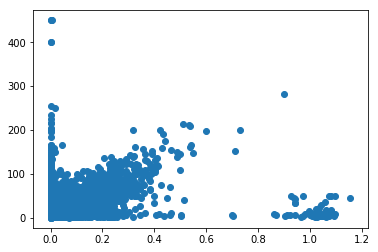

In [87]:
# Finding Distance and Fare Correlation
distance_fare_correlation = df_train['distance'].corr(df_train['fare_amount'], method='pearson')
print(distance_fare_correlation)

# Scatter Plot of Distance and Fare
import matplotlib.pyplot as plt

plt.scatter(df_train['distance'], df_train['fare_amount'])
plt.plot()

This scatter plot shows a high positive correlation between the distance travelled and fare_amount whis is 0.819. There seems to be a linear relation between fare and distance. It makes sense as fare increases with increasing distance linearly.

-0.031012930775137785


[]

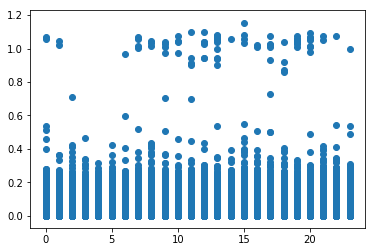

In [88]:
# Finding Time of Day(hour) and distance correlation
hour_distance_correlation = df_train['hour'].corr(df_train['distance'], method='pearson')
print(hour_distance_correlation)

# Scatter Plot of Hour and Distance
plt.scatter(df_train['hour'], df_train['distance'])
plt.plot()

This scatter plot shows that distance and time(hour of day) has very less negative correlation of -0.031. This may be because the density is different during different week days. Hour and distance also have non linear relation.

-0.019615850595663627


[]

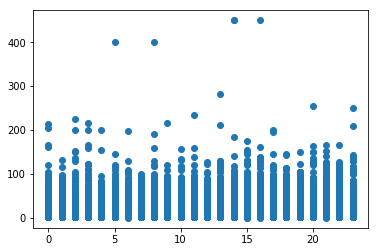

In [89]:
# Finding Hour and Fare Correlation
hour_fare_correlation = df_train['hour'].corr(df_train['fare_amount'], method='pearson')
print(hour_fare_correlation)

# Scatter Plot of Hour and Fare
plt.scatter(df_train['hour'], df_train['fare_amount'])
plt.plot()

This scatter plot shows that time and fare have very less negative correlation of -0.0196. This may be because fares don't change with time or may be because different weekdays have different distribution of time fare relation. There is a non-linear relation between fare and hour as can be seen in the plots done below.

From the above three plots, it can be seen that distance and fare have highest correlation.

In [90]:
# Adding additional features to the data
def add_features(df):
    df['year'] = df.pickup_datetime.apply(lambda x: x.year)
    df['month'] = df.pickup_datetime.apply(lambda x: x.month)
    df['day'] = df.pickup_datetime.apply(lambda x: x.day)
    df['weekday'] = df.pickup_datetime.apply(lambda x: x.weekday())
    
    from pandas.tseries.holiday import USFederalHolidayCalendar
    
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2009-01-01', end='2015-12-31').to_pydatetime()
    df['is_holiday'] = df['pickup_datetime'].apply(lambda x: 1 if x in holidays else 0)
    
    return df


df_train = add_features(df_train)
df_test = add_features(df_test)
print("Data Types after adding Features:")
print(df_train.dtypes)

Data Types after adding Features:
key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
distance                    float64
hour                          int64
year                          int64
month                         int64
day                           int64
weekday                       int64
is_holiday                    int64
dtype: object


Chose additional features of YEAR, MONTH, DAY, WEEKDAY, and IS_HOLIDAY, which were the first things to come in mind from the above scatter plots as well as looking at the different densities. Holiday was chosen as it seemed to be a distinguishing factor when people may go out more than in normal non-holiday day. So imported the data source of US Federal Holidays has been used from pandas package and each dataset is labelled 1 for holiday and 0 for non-holiday.

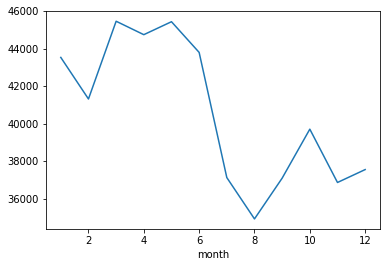

In [94]:
df_train.groupby('month')['key'].count().plot()

The above plot between month and number of rides show a minimum in August and comparable variation between months.

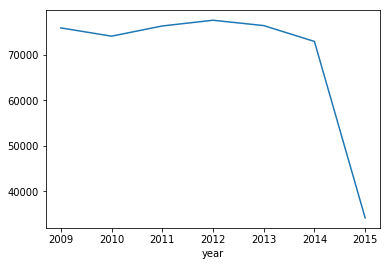

In [95]:
df_train.groupby('year')['key'].count().plot()

The above plot shows the data is pretty evenly distributed between the years and we don't have entire data of 2015 which is the reason for dip.

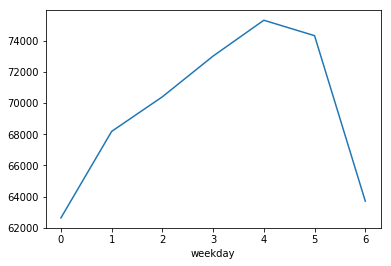

In [96]:
df_train.groupby('weekday')['key'].count().plot()

The above plot shows that friday and saturday are the days with most taxi usage and sunday and monday being the least. This may be because people are free from work on friday and go out a lot on these days.

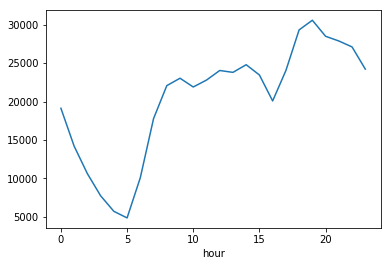

In [97]:
df_train.groupby('hour')['key'].count().plot()

This graph shows peak hour around 1900 hrs every day, may be the time when people get back from work or go out. It's minimum is at 0500 hrs.

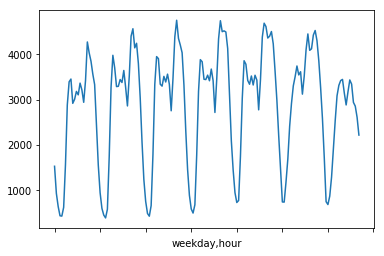

In [100]:
df_train.groupby(['weekday', 'hour'])['key'].count().plot()

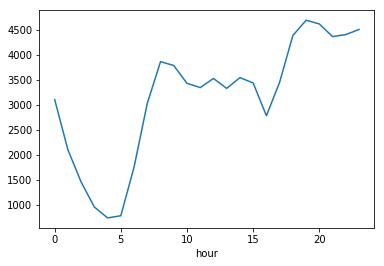

In [116]:
df_train[df_train['weekday'] == 4].groupby(['hour'])['key'].count().plot()

Plots like this on all week days show high taxi usage on friday night, saturday night. Rest all days have peak at around 1900 hrs and not much usage in the night after that. This helps us to take variable representing friday or saturday night as this is differentiating from other week days. We will try to incorporate this variable in our final improvement phase.

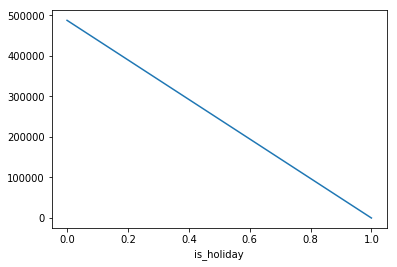

In [117]:
df_train.groupby('is_holiday')['key'].count().plot()

The number of rides is very less on holidays. This feature plays a part in training since we have days whose rides are very less and this feature proves why.

In [79]:
def feature_set(df):
    columns = ['distance', 'year', 'month', 'day', 'hour', 'weekday', 'is_holiday']
    df = df[columns]
    
    return df

df_target_set = df_train[['fare_amount']]
df_training_set = feature_set(df_train)
print("Data Types of final training set:")
print(df_training_set.dtypes)

Data Types of final training set:
distance      float64
year            int64
month           int64
day             int64
hour            int64
weekday         int64
is_holiday      int64
dtype: object


Choosing the features to train the final model on.

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error

# Linear Regression Model
def linear_regression(train, target, normalize=False):
    train, train_test, target, target_test = train_test_split(train, target)

    linear_regression = LinearRegression(normalize=normalize)
    linear_regression.fit(train, target)
    print(linear_regression.intercept_, linear_regression.coef_)

    target_prediction = linear_regression.predict(train_test)
    rms = np.sqrt(mean_squared_error(target_test, target_prediction))
    print(rms)
    
    return linear_regression
    
linear_regression(df_training_set, df_target_set)

[-1078.8569968] [[ 1.97021982e+02  5.38330542e-01  7.50986327e-02  1.61208368e-03
   7.05998739e-03 -3.41771903e-02 -2.72672082e+00]]
5.546056554236399


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Training the linear regression model and predicting on the test data which is split from the chosen training data without normalization and choosing the above features gives rmse of 5.54. The coefficients are printed and it can be seen that distance has highest weight of 197. So it's the most important feature. Holiday is the second important feature with a weight of -2.726 followed by year with 0.538. Other features contribute less comparatively.
* Distance : 197.021982
* Year     : 0.538330542
* Month    : 0.0750986327
* Day      : 0.00161208368
* Hour     : 0.00705998739
* Weekday  : -0.0341771903
* Holiday  : -2.72672082

In [81]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
def random_forest_regressor(train, target):
    train, train_test, target, target_test = train_test_split(train, target)
    random_forest_regressor = RandomForestRegressor(n_estimators=25, max_features=None, max_depth=25, 
                                                    min_samples_split=3, min_samples_leaf=2, random_state=0)
    random_forest_regressor.fit(train, target)
    target_prediction = random_forest_regressor.predict(train_test)
    rms = np.sqrt(mean_squared_error(target_test, target_prediction))
    print(rms)
    
    return random_forest_regressor
    
random_forest_regressor(df_training_set, df_target_set)

4.902812414231889


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

To improve on the Linear regression model, used random forest to predict fare on same features. It performs well and gives an RMSE of 4.902 on test data split from training set. It is an improvement on the Linear Regression model done previously.

In [82]:
import xgboost as xgb

# XGBoost
def xg_boost(train, target):
    train, train_test, target, target_test = train_test_split(train, target)
    matrix_train = xgb.DMatrix(train, label=target)
    matrix_test = xgb.DMatrix(train_test, label=target_test)
    xgboost_model = xgb.train(params={'objective': 'reg:linear', 'eval_metric': 'rmse'},
                      dtrain=matrix_train, num_boost_round=100,
                      early_stopping_rounds=25, evals=[(matrix_test, 'test')])
    
    return xgboost_model
    
xg_boost(df_training_set, df_target_set)


[20:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[0]	test-rmse:10.6296
Will train until test-rmse hasn't improved in 25 rounds.
[20:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	test-rmse:8.08862
[20:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[2]	test-rmse:6.48381
[20:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[3]	test-rmse:5.5143
[20:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[4]	test-rmse:4.9639
[20:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[5]	test-rmse:4.67076
[20:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[6]	test-rmse:4.51562


Then chose XGBoost model to get the RMSE which comes to be around 4.33 for 100 iterations. It is an improvement on the Random Forest as well as Linear Regression models.

External Datasets:
* Used holiday dataset of pandas as explained above.
* Weather dataset can make a decent contribution as the prices will definitely depend on the weather as the traffic and other reasons for waiting may be more on few days.

Improvements:
* As discussed in the above plots we can take a feature weekend_night which includes times between 2000 and 0400 on friday and saturday.
* Location specific data will be helpful as it would help divide the regions so that we can more precisely predict the prices. This is because different regions experience different congestion and prices may adjust accordingly. Other impacts can be the distance of the trips since malls and other places may be far from some regions.
* Long distance travel, which is common when visiting famous places in New York and other from Air Ports. The price for such high distance travel may be less than the ususl short-distance travels. This can be seen in the distance scatter plot where fares of long distance travels are comparatively lower or discounted and seem fixed
* Weather dataset can be helpful since the congestion and other criteria for pricing may depend on that.
* Using better distance function like haversine distance function.

Based on the above the following features may be added:
* weekend_night: True if it's friday or saturday and time is 2000 - 0000 or if saturday or sunday between 0000 - 0400
* cluster the locations.
* distance from different airports

Note: Inspiration of clustering and airports has been taken from the following kernels.
https://www.kaggle.com/justjun0321/exploratory-geoclustering-to-modeling
https://www.kaggle.com/dimitreoliveira/taxi-fare-prediction-with-keras-deep-learning

Improving Model: 
* Normalization can be used to improve the Linear regression model.
* Scaling Features using standard scaler

In [ ]:
def haversine_distance(p_lat, p_lon, d_lat, d_lon):
    p_lon, p_lat, d_lon, d_lat = map(np.radians, [p_lon, p_lat, d_lon, d_lat])
    a = np.sin((d_lat - p_lat) / 2.0) ** 2 + np.cos(p_lat) * np.cos(d_lat) * np.sin((d_lon - p_lon) / 2.0) ** 2
    return 6367 * 2 * np.arcsin(np.sqrt(a)) * 0.62137


def is_weekend_night(row):
    if ((row['weekday'] == 4 or row['weekday'] == 5) and (row['hour'] >= 20)) or \
            ((row['weekday'] == 5 or row['weekday'] == 6) and (row['hour'] <= 4)):
        return 1
    else:
        return 0


# Adding additional features discussed above
def add_additional_features(df):
    df['distance'] = haversine_distance(df.pickup_latitude, df.pickup_longitude,
                                        df.dropoff_latitude, df.dropoff_longitude)
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)

    df['downtown_pickup_distance'] = haversine_distance(ny[1], ny[0], df.pickup_latitude, df.pickup_longitude)
    df['downtown_dropoff_distance'] = haversine_distance(ny[1], ny[0], df.dropoff_latitude, df.dropoff_longitude)
    df['jfk_pickup_distance'] = haversine_distance(jfk[1], jfk[0], df.pickup_latitude, df.pickup_longitude)
    df['jfk_dropoff_distance'] = haversine_distance(jfk[1], jfk[0], df.dropoff_latitude, df.dropoff_longitude)
    df['ewr_pickup_distance'] = haversine_distance(ewr[1], ewr[0], df.pickup_latitude, df.pickup_longitude)
    df['ewr_dropoff_distance'] = haversine_distance(ewr[1], ewr[0], df.dropoff_latitude, df.dropoff_longitude)
    df['lgr_pickup_distance'] = haversine_distance(lgr[1], lgr[0], df.pickup_latitude, df.pickup_longitude)
    df['lgr_dropoff_distance'] = haversine_distance(lgr[1], lgr[0], df.dropoff_latitude, df.dropoff_longitude)

    # df['weekend_night'] = df.apply(lambda x: is_weekend_night)
    return df


def cluster_locations(df):
    pickup_locations = df[['pickup_longitude', 'pickup_latitude']]
    model = KMeans(n_clusters=6)
    model.fit(pickup_locations)
    pickup_labels = model.predict(pickup_locations)
    df['pickup_cluster'] = pickup_labels

    dropoff_locations = df[['dropoff_longitude', 'dropoff_latitude']]
    model = KMeans(n_clusters=6)
    model.fit(dropoff_locations)
    dropoff_labels = model.predict(dropoff_locations)
    df['dropoff_cluster'] = dropoff_labels

    pickup_clusters = pd.get_dummies(df['pickup_cluster'], prefix='pickup_cluster', drop_first=False)
    dropoff_clusters = pd.get_dummies(df['dropoff_cluster'], prefix='dropoff_cluster', drop_first=False)

    df = pd.concat([df, pickup_clusters], axis=1).drop('pickup_cluster', axis=1)
    df = pd.concat([df, dropoff_clusters], axis=1).drop('dropoff_cluster', axis=1)
    return df


df_train = add_additional_features(df_train)
df_test = add_additional_features(df_test)
df_train = cluster_locations(df_train)
df_test = cluster_locations(df_test)

df_train = df_train.dropna()
print(df_train.shape)
print(df_train.dtypes)

In [ ]:
# Final Training Set
def final_feature_set(df):
    columns = ['distance', 'year', 'month', 'day', 'hour', 'weekday', 'is_holiday', 'downtown_pickup_distance',
               'downtown_dropoff_distance', 'jfk_pickup_distance', 'jfk_dropoff_distance', 'ewr_pickup_distance',
               'ewr_dropoff_distance', 'lgr_pickup_distance', 'lgr_dropoff_distance', 'pickup_cluster_0',
               'pickup_cluster_1', 'pickup_cluster_2', 'pickup_cluster_3', 'pickup_cluster_4', 'pickup_cluster_5',
               'dropoff_cluster_0', 'dropoff_cluster_1', 'dropoff_cluster_2', 'dropoff_cluster_3', 'dropoff_cluster_4',
               'dropoff_cluster_5']
    df = df[columns]
    return df


df_target_set = df_train[['fare_amount']]
df_train_set = final_feature_set(df_train)
df_test_set = final_feature_set(df_test)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scaling the training data using standard scaler
scaler = StandardScaler()
scaler.fit(df_train_set)
df_train_set = scaler.transform(df_train_set)
df_test_set = scaler.transform(df_test_set)

In [ ]:
# Final Prediction
lr = linear_regression(df_train_set, df_target_set, normalize=True)
# rf = random_forest_regressor(df_train_set, df_target_set)
# xm = xg_boost(df_train_set, df_target_set)

df_target_prediction_lr = lr.predict(df_test_set)
# df_target_prediction_rf = rf.predict(df_test_set)
# df_target_prediction_xg = xm.predict(xgb.DMatrix(df_test_set), ntree_limit=model.best_ntree_limit)

file_csv = pd.read_csv('sample_submission.csv')
file_csv['key'] = df_test['key']
file_csv['fare_amount'] = df_target_prediction_lr
file_csv.to_csv("submission_lr.csv", index=False)